# SP 9, "Mass Cash": Problem 3

The "Mass Cash" lottery randomly chooses $5$ of the numbers from $1, 2, ..., 35$ each day (without repeitions within the choice of $5$ numbers). Suppose that we want to know how long it will take until all numbers have been chosen.

Let $a_{j}$ be the average number of _additional_ days needed if we are missing $j$ numbers (so $a_{0} = 0$ and $a_{35}$ is the average number of days needed to collect all $35$ numbers). Find a recursive formula for the $a_{j}$'s.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

In [2]:
# Import dependencies
import random
import pandas as pd
from functools import lru_cache
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
from math import floor, ceil, factorial, comb

## Numerical Solution 

The `generate_sim_data` function runs the simulation and produces a dataframe indexed on $j$.

In [3]:
def sim_mass_cash_iterate(balls: tuple, unused_balls: set, draws_per_day: int = 5) -> int:
    """
    Simulation counting the number of days required to have appearance of each ball
    at least once given each day's draw consists of 5 balls without replacement
    """
    days = 0
    while unused_balls:
        draw = set(random.sample(balls, draws_per_day))
        unused_balls -= draw
        days += 1

    return days    

In [4]:
def generate_sim_data(num_balls: int = 35, draws_per_day: int = 5, N: int = 50_000) -> pd.DataFrame:
    """
    Returns dataframe of simulation data parameterized by the arguments to the function
    """
    # Mass Cash numbered balls
    balls = tuple(x for x in range(1, num_balls + 1))

    # Run simulation lots of times and average
    trial_data = np.array(
        [sim_mass_cash_iterate(balls, set(balls), draws_per_day=draws_per_day) 
         for _ in range(N)]
    )
    
    # Generate data
    data = OrderedDict()
    unused_balls = list(balls)
    while len(data) < num_balls:
        data[len(unused_balls)] = np.array(
            [sim_mass_cash_iterate(balls, set(unused_balls), draws_per_day=draws_per_day) 
             for _ in range(N)]
        ).mean()
        unused_balls.pop()

    # Add base case
    data[0] = 0.0
    
    # Gather data
    df = pd.DataFrame.from_dict(data, orient='index', columns=['a_j'])
    df['delta'] = df['a_j'] - df['a_j'].shift(-1)
    
    return df

Running the simulation yields the following estimate for $a_{35}$:

In [5]:
# Average number of days needed to collect all numbers
df = generate_sim_data()
df.loc[35, 'a_j']

27.71368

Let's construct a plot for all $a_{j}$!

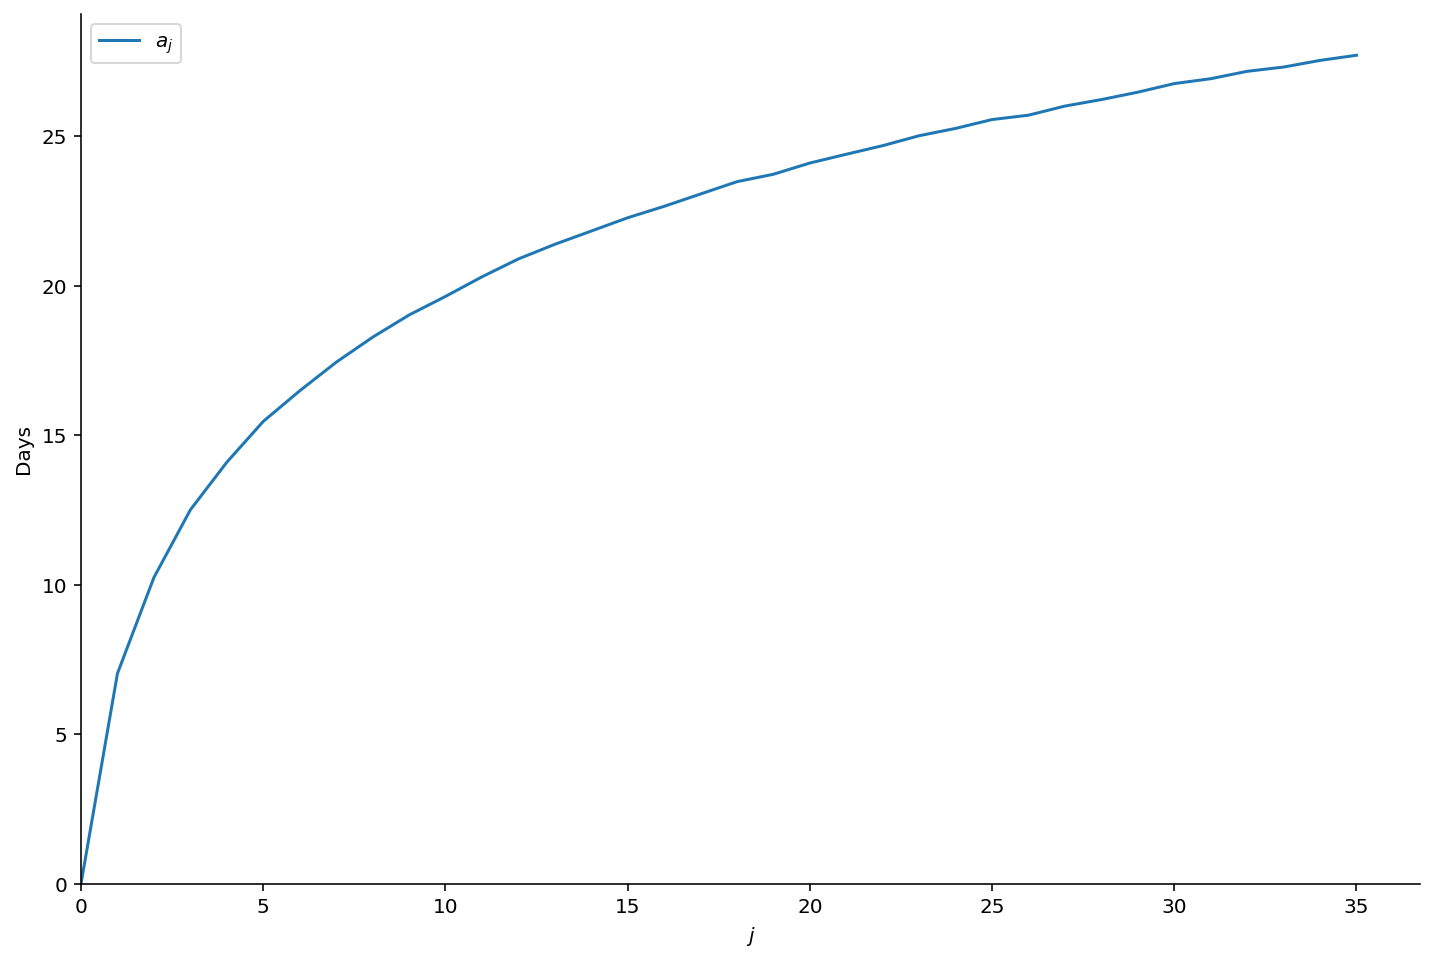

In [6]:
# Plot data
plt.figure(figsize=(12,8))
plt.plot(df['a_j'], label='$a_j$')

# Cosmetic adjustments
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.xlabel('$j$')
plt.ylabel('Days')
plt.legend()

plt.show()

## Analytical Solution 

<a id=’Observation’></a>
#### Observation

Notice that $a_{1} = E(T_{1})$ where $T_{1} \sim \text{FS}(p)$ and $p$ is the probability the last remaining ball is drawn in the daily lotto drawing. Here, I'm following the convention that a random variable $X \sim \text{FS}(p)$ counts the number of Bernoulli trials (where each trial "succeeds" with probability $p$) until the the first "success", _inclusive_ of the "success".

This means that $p = \frac{1}{7} \implies E(T_{1}) = 7$ by symmetry because all arrangements of 35 balls are equally likely and the missing one has $5(\frac{1}{35}) = \frac{1}{7}$ probability of being among the first 5 drawn. This is confirmed by the simulation above.

Zooming out for a second, we notice that the structure of the problem is similar to the ["coupon collector" problem](https://en.wikipedia.org/wiki/Coupon_collector%27s_problem) from Chapter 4. 

The "coupon collector" problem asked how long we had to wait (in terms of trials, where each trial produces a coupon) until all coupon types (or varieties) were collected. The wrinkle in the "Mass Cash" problem is that each trial (day) is a set of $5$ balls whereas in the normal "coupon collector" problem each trial consists of one draw.

### Strategy: Simple, Non-Trivial Case

Hmmmm...I'm still a little stuck connecting the dots between the "coupon collecting" problem and my intuitive understanding of iterated expectation, so let's try to solve a simpler (but non-trivial) problem.

Rather than $35$ balls and $5$ drawn daily without replacement, let's try to solve the same problem with $4$ balls and $2$ drawn daily.

In [7]:
# To check analytical result with numerical approximation
df_simple = generate_sim_data(4, 2)

Let's try to back into each of the $a_{j}$ by considering conditional expectations. We know that $a_{0} = 0$. Using the same reasoning above (see **[Observation](#Observation)**) we get $a_{1} = 2$.

Now things get interesting. We notice that after Day 1, we _always_ get to a point where we need to calculate $a_{2}$ since the $2$ drawn balls, tautologically, are "never-before-seen" or new numbers.

There are $3$ cases to condition on:

1. $0$ new numbers are drawn (i.e., the exact same numbers are drawn on Day 2 as were drawn before \[on Day 1\])
2. $1$ new number is drawn (i.e., the other number was already observed before \[on Day 1\])
3. $2$ new numbers are drawn (i.e., we have observed all balls over Day 1 and Day 2)

After we observe Day 2's result, we can use iterated expectation to solve for $a_{2}$ in terms of $a_{1}$ and $a_{0}$:

$$
\begin{align}
a_{2} &= \frac{4}{4!}(a_{2} + 1) + \frac{16}{4!}(a_{1} + 1) + \frac{4}{4!}(a_{0} + 1)\\
a_{2} &= 1 + \frac{1}{6}a_{2} + \frac{2}{3}a_{1}\\
a_{2} &= \frac{14}{5} = 2.8
\end{align}
$$

In [8]:
# Check a_2 result
df_simple.loc[2, 'a_j']

2.79608

We proceed similarly for $a_{3}$, even if we know in reality we will never observe a situation when we have exactly $3$ unobserved balls (from the fact that Day 1's result always leaves us with $2$ remaining, unseen balls).

Looking at the pattern that's emerging it's clear that we're conditioning on the cases where there are $j \geq 0$ balls remaining _after_ the last draw.

But notice that the case that we need to see $3$ more balls again after the latest draw is impossible since we're drawing $2$ balls per day and $j=3$ implies we've only seen one ball. Even if we drew this ball again, we are guaranteed to see at least $1$ new ball. Furthermore, there's no way we can be done (i.e., having seen all the balls after the latest draw) because we are only drawing $2$ balls at a time and we're missing $3$ balls -- this means that the probability of being done ($j = 0$) is $0$.

$$
\begin{align}
a_{3} &= 0(a_{3} + 1) + \frac{12}{4!}(a_{2} + 1) + \frac{12}{4!}(a_{1} + 1) + 0(a_{0} + 1)\\
a_{3} &= \frac{1}{2}\left(\frac{19}{5}\right) + \frac{1}{2}(3)\\
a_{3} &= \frac{17}{5} = 3.4
\end{align}
$$

In [9]:
# Check a_3 result
df_simple.loc[3, 'a_j']

3.40352

Calculating $a_{4}$ in the same way yields:

$$
\begin{align}
a_{4} &= 0(a_{4} + 1) + 0(a_{3} + 1) + 1(a_{2} + 1) + 0(a_{1} + 1) + 0(a_{0} + 1)\\
a_{4} &= \frac{14}{5} + 1 = 3.8
\end{align}
$$

This is like being in Day 0 and conditioning on all the events that could occur after Day 1's draw. As noted above, we will always observe $2$ new balls and always need to calculate the average number of days to get the remaining $2$ balls (and add it to the one day that transpired, i.e., Day 1).

In [10]:
# Check a_4 result
df_simple.loc[4, 'a_j']

3.8044

### General Analytical Solution

With this example under our belt, we can transcribe the pattern we see into a recursive expression. Basically, **we are conditioning on the outcome of a draw knowing what $j$ is going into that draw**. Over time the number of "remains-to-be-seen" balls decreases (with enough days passing by!), so we know the outcomes ($k$ describes how many balls are left _after_ we see the draw) are bounded: either the draw gives new numbers ($k < j$) or the draw doesn't yield any new numbers ($k = j$).

For "Mass Cash", we can formalize these ideas:

$$
\begin{align}
a_{j} &= \sum_{k=0}^{j} \binom{5}{k}\binom{30}{j-k} \frac{j!(35-j)!}{35!} (a_{j-k} + 1)\\
&= 1 + \sum_{k=0}^{j} \frac{\binom{5}{k}\binom{30}{j-k}}{\binom{35}{j}} (a_{j-k})
\end{align}
$$

Notice that there is a Hypergeometric PMF embedded in the sum. Letting $N$ count the number of never-before-seen balls from the draw, $N \sim \text{HGeom}(5, 30, j)$. We can also express $a_{j-k} + 1$ as $E(T_{j} | N)$, where $T_{j}$ counts the number of days until the remaining $j$ balls are drawn at least once. Hence, the equivalence (by ["Adam's Law"](https://youtu.be/gjBvCiRt8QA?t=636)):

$$
\begin{align}
a_{j} =& \sum_{k=0}^{j} \binom{5}{k}\binom{30}{j-k} \frac{j!(35-j)!}{35!} (a_{j-k} + 1)\\
\Updownarrow&\\
E(T_{j}) =& E(E(T_{j} | N))
\end{align}
$$

To check our solution, let's compare $a_{j}$ with our numerical estimates. 

We can write the general formula as follows for the lotto scenario with $w$ balls and $v$ draws from these balls without replacement:

$$
a_{j} = \sum_{k=0}^{j} \binom{v}{k}\binom{w-v}{j-k} \frac{j!(w-j)!}{w!} (a_{j-k} + 1)
$$

In [11]:
@lru_cache
def analytical_solution_mass_cash(w: int = 35, v: int = 5, j: int = 35) -> float:
    """
    Calculates the analytical solution for expected number of trials until
    all w unique items in a set are drawn where each trial is a random draw without
    replacement of v items.
    
    Parameters:
        w: number of unique items
        v: number of draws without replacements
        j: remaining number of items not yet drawn
        
    Returns:
        a_j: expected number of additional days needed to collect all unique items
    """

    # Base case
    if j == 0:
        return 0
    
    # Recursive case
    ex_a_j_terms = 0
    for k in range(1, j + 1):
        p = comb(v, k) * comb(w-v, j-k) * factorial(j) * factorial(w-j) / factorial(w)
        ex_a_j_terms += p * (analytical_solution_mass_cash(w, v, j-k) + 1)
    
    # Note: k = 0 case is separated because it would case stack overflow if 
    # included in the for-loop above
    k = 0
    p_j = comb(v, k) * comb(w-v, j-k) * factorial(j) * factorial(w-j) / factorial(w)
    a_j = (ex_a_j_terms + p_j)  / (1 - p_j)
        
    return a_j

In [12]:
# Check and compare solutions
w = 35
v = 5
j = 35
print(f"""
    Analytical solution: {analytical_solution_mass_cash(w, v, j):0.3f}
    Numerical approximation: {df.loc[j, 'a_j']:0.3f}
""")


    Analytical solution: 27.718
    Numerical approximation: 27.714



(Feel free to change `df` to `df_simple` and use `w=4`, `v=2`, `j=4` to verify the results from the simplified problem above.)

**NOTE**: The simulation could be re-written to be more efficient!